# Introduction
This is the code module which creates the results for the multi step process

# Imports

In [90]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
import numpy as np
# from tensorflow_addons.losses import pinball_loss
from tensorflow import function as tf_fun
from tensorflow import keras
from tensorflow.keras import Model
from math import log, sqrt, exp, erf, ceil, floor
from tqdm.notebook import tqdm, trange
import pandas as pd
from math import ceil

import scipy.stats as stats
from scipy.stats import qmc
import matplotlib.pyplot as plt
import seaborn as sns

from time import perf_counter
from scipy.stats import norm
from matplotlib import ticker

from importlib import reload

from numpy.random import seed   
from tensorflow.random import set_seed as tf_seed

tf_seed(1234) ; seed(1234)

plt.rcParams["figure.figsize"] = (20, 7)
plt.rcParams["font.size"] = 13
plt.style.use('bmh')

# Simulate W1 & W2 Pahs

In [91]:
# Sobol - Quasi Monte Carlo for path simulation
def sobol_norm(m, d=1 ,seed=1234):
    sampler = qmc.Sobol(d, scramble=True, seed=seed)
    x_sobol = sampler.random_base2(m)
    return stats.norm.ppf(x_sobol)

In [92]:
""" Global Variables """
n_paths   = ceil(np.log2(3_000)) ; print(f'Paths: {2**n_paths:,.0f}')# for both Y and N
dt        = 1/(365) # Local: use greater than 42

rebalancing = 1/4 # Quarterly

P = 100 # premium per client
N = 10_000
ADJUSTMENT_FACTOR = P * N

Paths: 4,096


## Y - Standard Geometric Brownian Motion

Number of steps: 3651 
dt         = 0.003 year
----------------------------------------------------------------
Time to simulate: 0.967sec
mean Yt    = 2.227189
e^(mu * T) = 2.225541 
Diff       = 0.001648



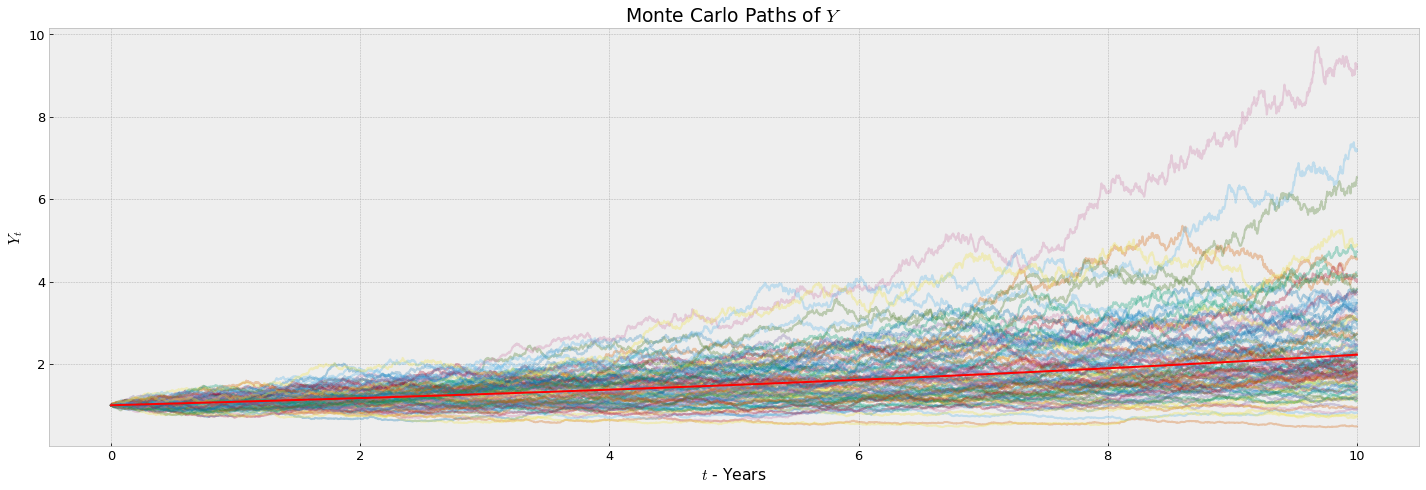

In [93]:
Y       = 1 # Starting value of stock
T       = 10 # Years
mu      = 0.08 #drift parameter
r       = 0.03 # risk
sigma   = 0.15

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

timer=perf_counter()

""" Simulate Fund Price """
W1      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
Y_paths[:,0] = Y

print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    Y_paths[:,t] = Y_paths[:,t-1] + Y_paths[:,t-1] * (mu*dt + sigma * np.sqrt(dt)*W1[:,t]).squeeze()

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

print(f'mean Yt    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
ax = rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y_t$', xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of $Y$') 
ax.plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r') ; plt.tight_layout() ; plt.plot() ; print()

## Y - Geometric Brownian Motion w/ Stochastic Volatility - Cox-Ross - w/ Calibrated paramters
$$
Y(t+dt)=Y(t)exp\{(\mu+\frac{1}{2}\sigma(t)^2)dt+\sigma(t)\sqrt{dt}W_1\}\\
\sigma(t+dt) = \sigma(t)+ a(b-\sigma(t))+ c\sqrt{\sigma(t)dt}W_2
$$

Number of steps: 3651 
dt         = 0.003 year
----------------------------------------------------------------
Time to simulate: 1.903sec
E[Y(T)]    = 2.578681
e^(mu * T) = 2.576418 
Diff       = 0.002263



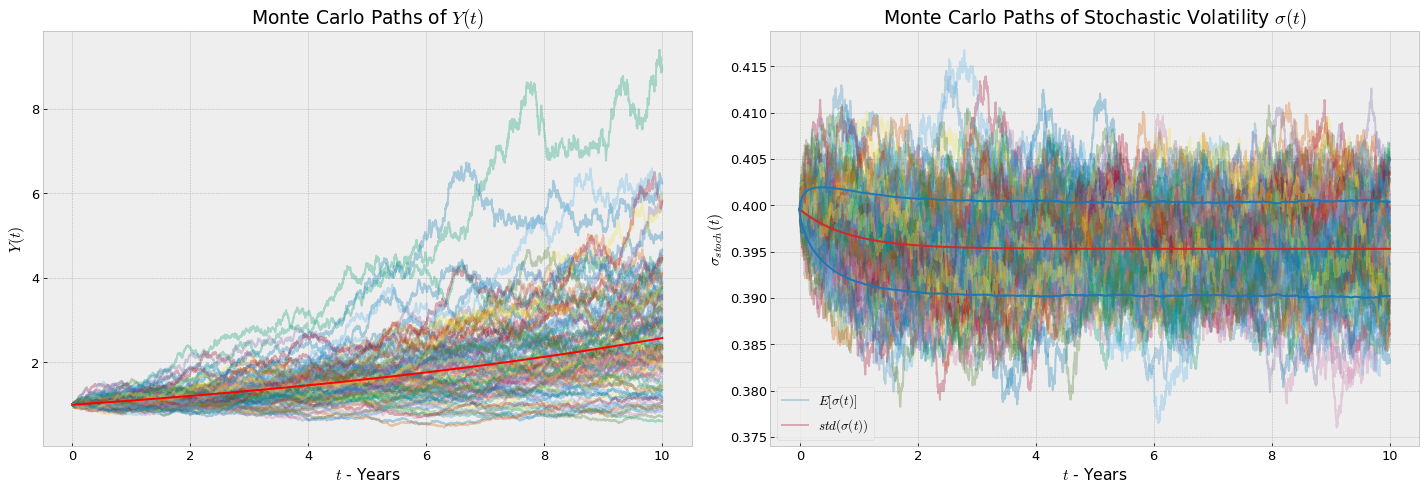

In [94]:
Y       = 1 # Starting value of stock
T       = 10 # Years
mu      = 0.09464 #drift parameter
r       = 0.03 # risk free interest rate
sigma_0 = 0.15965

n_time_steps = ceil(T/dt)+1 ; print(f'Number of steps: {n_time_steps} \ndt         = {dt:.3f} year')

timer = perf_counter()

# stochastic volatility parameters - Cox-Ross model
s0 = sigma_0 # initial volatility at t=0
a=0.0033281299103885727
b=0.1562947229160206
c=0.01583113545983743

""" Simulate Fund Price """
W_S      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
W_V      = sobol_norm(n_paths, d=n_time_steps, seed=1235)
Y_paths = np.empty((2**n_paths, n_time_steps))
Y_paths[:,0] = np.log(Y)

""" SV - Verion """
vt = np.full(shape=(int(2**n_paths),n_time_steps), fill_value=s0) # initial variance 
print('----------------------------------------------------------------')
for t in range(1,n_time_steps):
    # Simulate log asset prices
    Y_paths[:,t] = Y_paths[:,t-1] + ((mu - 0.5*vt[:,t]**2)*dt + vt[:,t]*np.sqrt(dt)*W_S[:,t])
    # Simulate variance processes
    vt[:,t] = vt[:,t-1] + a*(b - vt[:,t-1]) + c*np.sqrt(vt[:,t-1]*dt)*W_V[:,t]
Y_paths = np.exp(Y_paths)

""" Generate Bond Data """
B = np.exp(r*np.linspace(0,T, n_time_steps))
B = np.broadcast_to(B, Y_paths.shape)
print(f'Time to simulate: {perf_counter()-timer:.3f}sec')

print(f'E[Y(T)]    = {np.nanmean(Y_paths[:,-1]):.6f}')
print(f'e^(mu * T) = {np.exp(mu*T):.6f} \nDiff       = {np.nanmean(Y_paths[:,-1])-Y*np.exp(mu*T):.6f}')

fig, (ax1, ax2) = plt.subplots(1, 2)
rdf = pd.DataFrame(Y_paths.T, index=(np.linspace(0,T, n_time_steps)))
rdf.sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$Y(t)$', xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of $Y(t)$', ax=ax1) 
ax1.plot(np.linspace(0,T, n_time_steps), np.exp(mu*np.linspace(0,T, n_time_steps)), c='r')

pd.DataFrame(np.sqrt(vt).T, index=(np.linspace(0,T, n_time_steps)))\
    .sample(100, axis=1).plot(legend=False, alpha=.3, ylabel=r'$\sigma_{stoch}(t)$', \
        xlabel=r'$t$ - Years', title=r'Monte Carlo Paths of Stochastic Volatility $\sigma(t)$', ax=ax2) 
ax2.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).mean(axis=0), c='tab:red')
ax2.plot(np.linspace(0,T, n_time_steps), np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
ax2.plot(np.linspace(0,T, n_time_steps), -np.sqrt(vt).std(axis=0) + np.sqrt(vt).mean(axis=0), c='tab:blue')
ax2.legend([r'$E[\sigma(t)]$', '$std(\sigma(t))$'])
fig.tight_layout() ; plt.plot() ; print()

# N(T) - Simulation
$$
\begin{align*}
&\lambda(t+dt) &= &\lambda(t)+[\gamma\lambda(t) dt + \eta \sqrt{dt}W_3(t)]& \\
\\
    &P_N(t) &= &e^{-\int_{t}^{t+dt} \lambda(t) dt} = e^{-\lambda(t) dt}& \\
    &N(t+dt) &= &Binomial(N(t),P_N(t))&\\
\\
&\lambda &:&\textit{ force of mortality}\\
&P_N&:&\textit{ binomial probability}\\
\end{align*}
$$

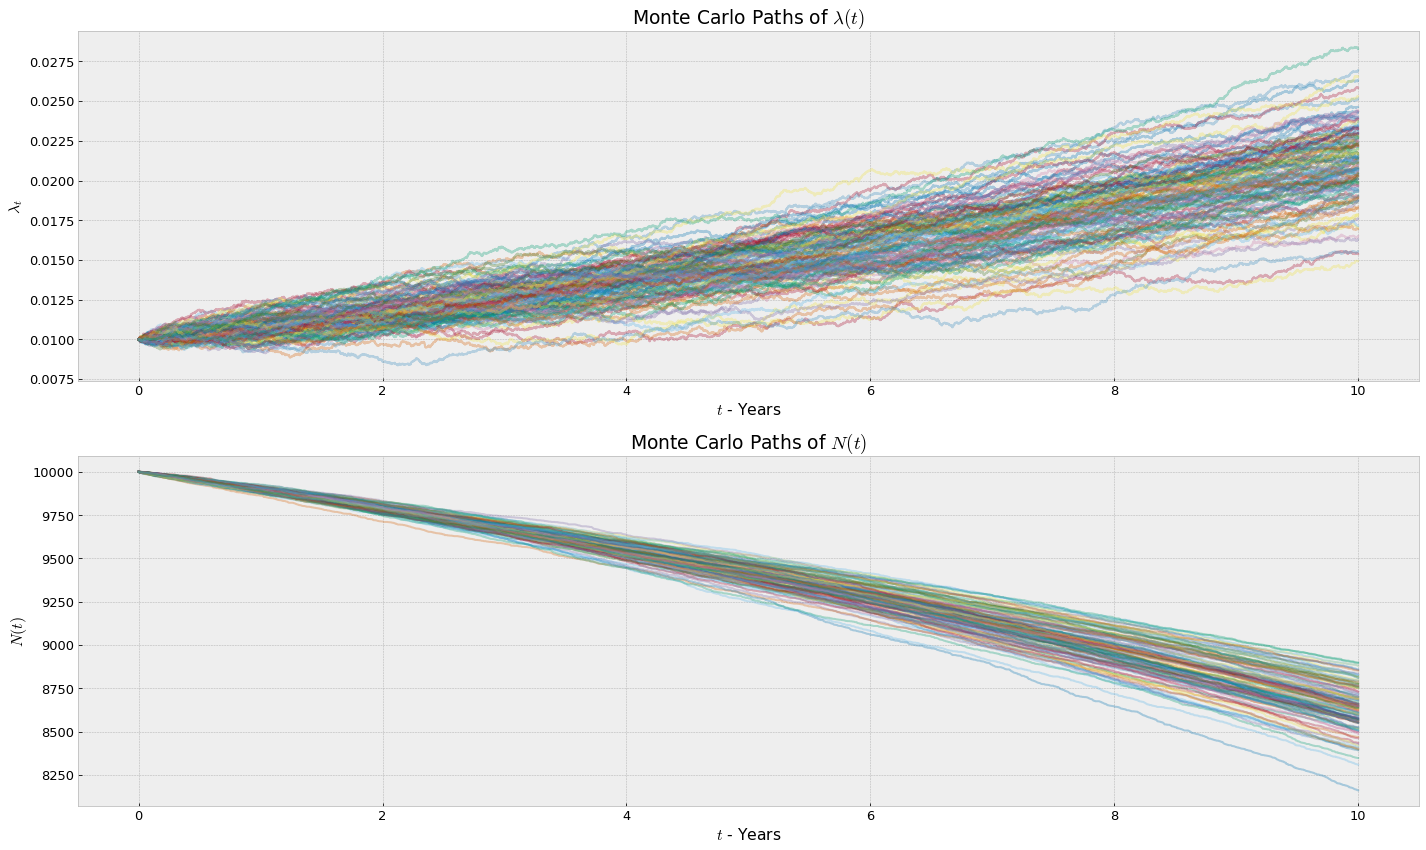

Statistics about N(T) 
---------------------
count   4,096
mean    8,617
std       133
min     8,114
50%     8,617
90%     8,789
95%     8,838
99%     8,930
max     9,200


In [95]:
x   = 55.0 # years old
l0  = 0.01
c   = 0.075
ita = 0.000597

W2      = sobol_norm(n_paths, d=n_time_steps)
L_paths = np.empty((2**n_paths, n_time_steps))
L_paths[:,0] = l0
for t in range(1,n_time_steps):
    L_paths[:,t] = L_paths[:,t-1] + (c * L_paths[:,t-1] * dt + ita * np.sqrt(dt)*W2[:,t]).squeeze()

N_paths = np.empty((2**n_paths, n_time_steps), dtype=int)
N_paths[:,0] = N
""" Binomial Distribution of N(t) """
for t in range(1,n_time_steps):
    probabilities = np.exp(-L_paths[:,t]*dt)
    np.random.seed(1234+t) # to ensure reproducible results
    N_paths[:,t]  = np.random.binomial(N_paths[:,t-1], probabilities)

fig, axs = plt.subplots(2, figsize=(20,12))

Ldf = pd.DataFrame(L_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ldf.sample(128, axis=1).plot(drawstyle="steps-post", legend=False, alpha=.3, ylabel=r'$\lambda_t$', xlabel=r'$t$ - Years', ax=axs[0], title=r'Monte Carlo Paths of $\lambda(t)$') 

Ndf = pd.DataFrame(N_paths.T, index=(np.linspace(0,T, n_time_steps)))
Ndf.sample(128, axis=1).plot(legend=False, alpha=.3, ylabel=r'$N(t)$', xlabel=r'$t$ - Years', ax=axs[1], title=r'Monte Carlo Paths of $N(t)$') 

plt.tight_layout() ; plt.show()

str_form = lambda s: f'{s:,.0f}'
print('Statistics about N(T) \n---------------------')
print(Ndf.loc[10].describe(percentiles=[.90, .95, .99]).to_string(float_format=str_form))


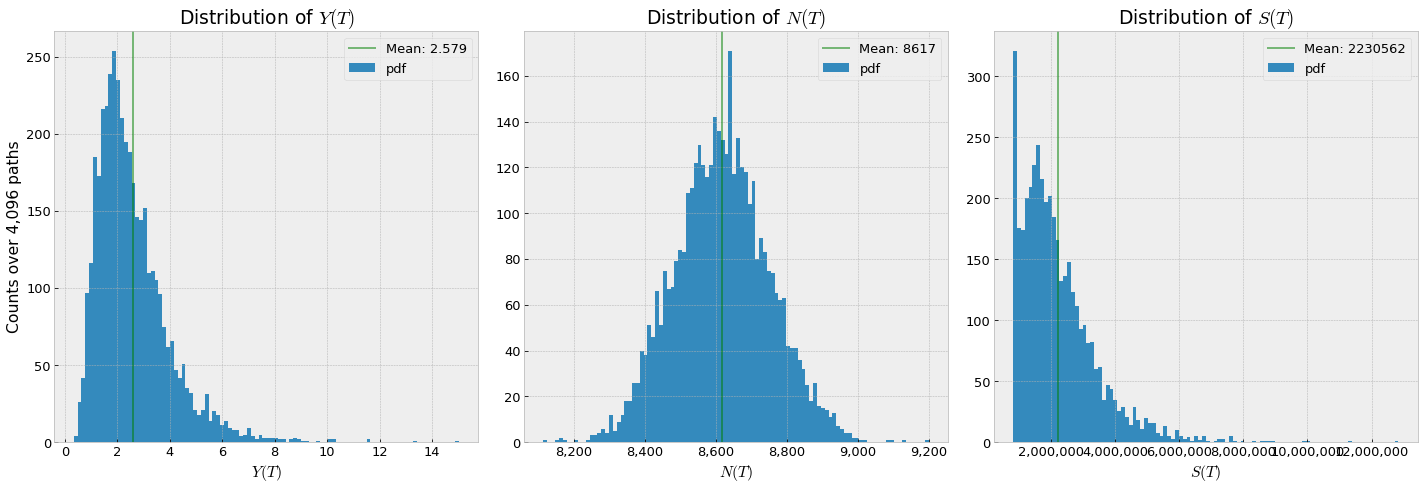

-------------------------------------
E[Y(T)]          = 2.589
E[Y(T)]*e^(-r*T) = 1.918
Prob Y(T) < Y(0) = 5.37%


In [96]:
""" Y, N, S - Plots """
fig, (ax1, ax2, ax3) = plt.subplots(1,3)

# Y plot
payoff_df = pd.Series(Y_paths[:,-1])
payoff_df.hist(bins=100, ax=ax1) ; ax1.set_title(r'Distribution of $Y(T)$')
ax1.axvline(payoff_df.mean(), color='g', linestyle='-', alpha=.5)
ax1.legend([f'Mean: {payoff_df.mean():.3f}', 'pdf'])
ax1.set_xlabel(r'$Y(T)$') ; ax1.set_ylabel(f'Counts over {Y_paths.shape[0]:,} paths')

# N(T) plot
E_N_T   = N_paths[:,-1].mean()
N_T     = pd.Series(N_paths[ N_paths[:,-1]>0 ,-1])
N_T.hist(bins=100, ax=ax2) ; ax2.set_title(r'Distribution of $N(T)$')
ax2.axvline(E_N_T, color='g', linestyle='-', alpha=.5)
ax2.legend([f'Mean: {E_N_T:.0f}', 'pdf'])
ax2.set_xlabel(r'$N(T)$')
ax2.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

# Liability S(T) plot
Payoff_Y     = np.where(Y_paths[:,-1] > Y, Y_paths[:,-1], Y)

S_T = Payoff_Y * P * N_paths[:,-1]
S_T_df = pd.Series(S_T)
S_T_df.hist(bins=100, ax=ax3) ; ax3.set_title(r'Distribution of $S(T)$')
ax3.axvline(S_T_df.mean(), color='g', linestyle='-', alpha=.5)
ax3.legend([f'Mean: {S_T_df.mean():.0f}', 'pdf'])
ax3.set_xlabel(r'$S(T)$') ; axs[1].set_ylabel(f'Density over {Y_paths.shape[0]:,} paths')
ax3.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

fig.tight_layout() ; plt.show()

# Liability statistics
print('-------------------------------------')
out_of_money_P  = np.where(Y_paths[:,-1] < Y, 1.0, 0.0).mean()
print(f'E[Y(T)]          = {Payoff_Y.mean():.3f}')
print(f'E[Y(T)]*e^(-r*T) = {np.exp(-r*T)*Payoff_Y.mean():.3f}')
print(f'Prob Y(T) < Y(0) = {out_of_money_P*100:.2f}%')

In [97]:
# print(f'Y_paths.shape = {Y_paths.shape}')
reduction       = floor((n_time_steps-1)/(T/rebalancing))   ; print(f'reduction = {reduction}')
Y_paths         = Y_paths[:, slice(0, None, reduction)]
B               = B[:, slice(0, None, reduction)]
N_paths         = N_paths[:, slice(0, None, reduction)]
n_time_steps  = ceil(n_time_steps/reduction) ; dt = rebalancing
Y_paths[:,-1].mean(), N_paths[:,-1].mean(), dt, Y_paths.shape, n_time_steps

reduction = 91


(2.5717981019258307, 8622.1201171875, 0.25, (4096, 41), 41)

# Liability S(t)
$$ S_T = N(T)*max(Y_T,Y_0)*Premium $$
$$ E[S_T] = avg(S_T) $$

Expected S_T = 2,231,849 EUR


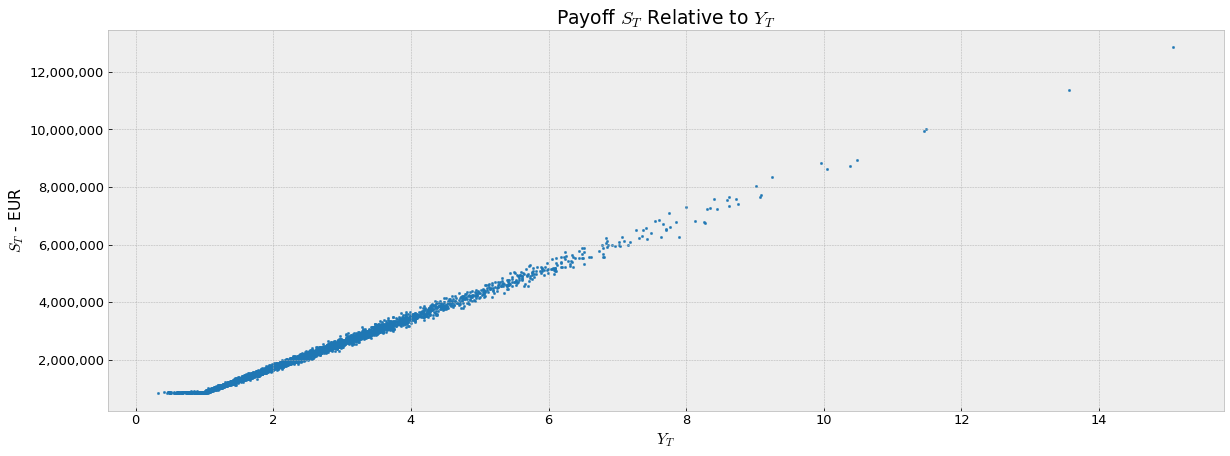

In [98]:
S_T = Payoff_Y * N_paths[:, -1] * P
_in = {'S_T': S_T, 'Y_T': Y_paths[:,-1]}
ax = pd.DataFrame.from_dict(_in).plot(kind='scatter', x='Y_T', y='S_T',xlabel=r'$Y_T$',ylabel=r'$S_T$ - EUR', title=r'Payoff $S_T$ Relative to $Y_T$', marker='.', color='tab:blue')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
print(f'Expected S_T = {S_T.mean():,.0f} EUR')

# Neural Network Hedging
$$
\begin{align*}
&\tilde{V_t}(\phi,\psi, Y_t, B_t) &=& \phi Y_t - \psi B_t\\

&\underset{\phi_1,\psi_1}{\mathrm{argmin}}\, R_1(\phi_1,\psi_1)
&=&\Big(V_t - \tilde{V_t}(\phi_1,\psi_1, Y_t, B_t) \Big)^2 \\

&\underset{\phi_2,\psi_2}{\mathrm{argmin}}\, R_2(\phi_2,\psi_2)
&=&max\Big[0.99\Big(V_t - \tilde{V_t}(\phi_2,\psi_2, Y_t, B_t) \Big), 0.01\Big(V_t - \tilde{V_t}(\phi_2,\psi_2, Y_T, B_T) \Big)\Big] \\
\\
&\phi_t &=& \phi_1 + i(\phi_2 - \phi_1)\\
&\psi_t &=& \psi_1 + i(\psi_2 - \psi_1)\\
\\
&\text{Therefore,}\\
&VaR_{0.99, t}\Big(S_T -(\phi_t Y_t + \psi_tB_t)\Big) &<& 0
\end{align*} \\
\\
$$

In [99]:
def get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values, Y_t, B_t):
    layer_output1=model1.get_layer('Phi_Psi').output
    pw_model1 = Model(inputs=[model1.input], outputs=[layer_output1])

    linear_layer_output1 = pw_model1.predict(X0)

    layer_output2 = model2.get_layer('Phi_Psi').output
    pw_model2 = Model(inputs=[model2.input], outputs=[layer_output2])

    linear_layer_output2 = pw_model2.predict(X0)

    phi = linear_layer_output1[:,0] + cost_of_capital * (linear_layer_output1[:,0] - linear_layer_output2[:,0])
    psi = linear_layer_output1[:,1] + cost_of_capital * (linear_layer_output1[:,1] - linear_layer_output2[:,1])

    for f  in phi: Phi_Psi_HV.append([f,  t_i*dt, 'Phi'])
    for ps in psi: Phi_Psi_HV.append([ps, t_i*dt, 'Psi'])

    VaR = values - phi * Y_t - psi * B_t

    print(f'VaR: {np.quantile(VaR, .98):4f} (98%),  {np.quantile(VaR, .99):4f} (99%)')
    for var in VaR: VaR_HV.append([var, (t_i+1)*dt])
    
    return Phi_Psi_HV, VaR_HV


def scheduler(epoch, lr):
    if epoch < 100 :
        return 1e-2
    elif epoch < 200 :
        return 1e-3
    elif epoch < 400 :
        return 5e-4
    else:
        return lr

@tf_fun
def quantile_loss(y, y_p):
        QUANTILE = .99
        e = y-y_p
        return keras.backend.mean(keras.backend.maximum(QUANTILE*e, (QUANTILE-1)*e))

lr_scheduler    = keras.callbacks.LearningRateScheduler(scheduler)
quantile_loss_f = lambda y, y_p : quantile_loss(y, y_p)

In [100]:
cost_of_capital = .1 

In [101]:
dense_initalizer = keras.initializers.RandomNormal(mean=0, stddev=0.1, seed=1234)
const_initalizer = keras.initializers.RandomNormal(mean=[1-out_of_money_P,out_of_money_P], stddev=0.0, seed=1234)

# model 1
Input_S_N = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N)
x = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x)
holdings = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x)

prices_1 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out    = keras.layers.Dot(axes = 1, name='V_t')([holdings, prices_1]) 

model1 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_MSE")

#model2
Input_S_N2 = keras.Input(shape=(3,), name='input: S_{t}, N_{t}, l_{t}') 
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_1', kernel_initializer=dense_initalizer)(Input_S_N2)
x2 = keras.layers.Dense(8, activation='LeakyReLU', name='LeakyReLU_2', kernel_initializer=dense_initalizer)(x2)
holdings2 = keras.layers.Dense(2, activation='linear', name='Phi_Psi', kernel_initializer=dense_initalizer, bias_initializer=const_initalizer)(x2)

prices_12 = keras.Input(shape=(2,), name='input: S_{t}, B_{t}')
S_out2    = keras.layers.Dot(axes = 1, name='V_t')([holdings2, prices_12]) 

model2 = keras.Model(inputs=[Input_S_N, prices_1], outputs=S_out, name="Replicating_Portfolio_Q99")
model1.summary()

Model: "Replicating_Portfolio_MSE"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input: S_{t}, N_{t}, l_{t} (Inp [(None, 3)]          0                                            
__________________________________________________________________________________________________
LeakyReLU_1 (Dense)             (None, 8)            32          input: S_{t}, N_{t}, l_{t}[0][0] 
__________________________________________________________________________________________________
LeakyReLU_2 (Dense)             (None, 8)            72          LeakyReLU_1[0][0]                
__________________________________________________________________________________________________
Phi_Psi (Dense)                 (None, 2)            18          LeakyReLU_2[0][0]                
__________________________________________________________________________

In [102]:
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=7, restore_best_weights=True)
model1.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = 'mse', run_eagerly=False, 
              metrics=["mae", "mape"])
model2.compile(optimizer = keras.optimizers.Adam(learning_rate=1e-3),
              loss = quantile_loss_f, run_eagerly=False, 
              metrics=["mae", "mape"])

N_paths_NN      = N_paths / N
values          = np.empty_like(Y_paths)
values[:,-1]    = Payoff_Y * N_paths_NN[:,-1] 
E_payoff        = (values[:,-1]).mean()

""" Calculate: Payoff for Options """
Flag = True ; its = 0
Errors      = np.zeros((1,2))
P_E_Values  = np.ones((1,3)) * values[:,-1].mean()
VaR_HV      = []
Phi_Psi_HV  = []
for t_i in trange(n_time_steps-2, -1, -1):
    print(f'\n>> Y_({(t_i+1)*dt:.2f}) = {Y_paths[:,t_i+1].mean():.3f}, N_({(t_i+1)*dt:.2f}) = {N_paths_NN[:,t_i+1].mean():.3f}')
    _Y_t  = Y_paths[:,t_i]
    _B_t  = B[:,t_i]
    _Y_t1 = Y_paths[:,t_i+1]
    _B_t1 = B[:,t_i+1]

    X0 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t, _B_t), axis=-1)]
    X1 = [np.stack((_Y_t, N_paths_NN[:,t_i], L_paths[:,t_i]), axis=-1), np.stack((_Y_t1, _B_t1), axis=-1)]

    epochs = 500
    if Flag :
        # print(f'S.mean: {S.mean():.5f}\nP.mean: {model.predict(X0, verbose=0, batch_size=512).squeeze().mean():.5f}')
        callabacks = [lr_scheduler, keras.callbacks.EarlyStopping(monitor='loss', patience=50, restore_best_weights=True)]
    else : 
        epochs = 100 
        callabacks = [callback]

    model1.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)
    g_t  = model1.predict(X0, verbose=0, batch_size=512).squeeze()
    g_t1 = model1.predict(X1, verbose=0, batch_size=512).squeeze()

    Errors = np.append(Errors, np.array(model1.evaluate(X1, values[:,t_i+1], batch_size=512)[1:]).reshape(1,2), axis=0)
    
    model2.fit(X1, values[:,t_i+1], epochs=epochs, validation_split=0.0, verbose=0, batch_size=512, callbacks=callabacks) #, initial_epoch= 200 if t_i != n_time_steps-2 else 0)    
    h_t  = model2.predict(X0, verbose=0, batch_size=512).squeeze()
    h_t1 = model2.predict(X1, verbose=0, batch_size=512).squeeze()

    values[:,t_i] = g_t + cost_of_capital*(h_t - g_t)

    """ Update phi-psi and VaR """
    Phi_Psi_HV, VaR_HV = get_phi_psi_VaR(model1, model2, X0, Phi_Psi_HV, VaR_HV, cost_of_capital, values[:,t_i+1], _Y_t1, _B_t1)

    its += 1 ; Flag = False 
    P_E_Values = np.append(P_E_Values, np.array([values[:,t_i].mean(), E_payoff*np.exp(-mu*dt*its), E_payoff*np.exp(-r*dt*its)]).reshape(1,3), axis=0)


  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.572, N_(10.00) = 0.862
8/8 [==============================] - 0s 4ms/step - loss: 0.0057 - mae: 0.0541 - mape: 2.4921
VaR: -0.013372 (98%),  0.000700 (99%)

>> Y_(9.75) = 2.511, N_(9.75) = 0.867
8/8 [==============================] - 0s 4ms/step - loss: 1.5699e-04 - mae: 0.0064 - mape: 0.4477
VaR: 0.000072 (98%),  0.000555 (99%)

>> Y_(9.50) = 2.452, N_(9.50) = 0.871
8/8 [==============================] - 0s 5ms/step - loss: 9.1765e-05 - mae: 0.0036 - mape: 0.3136
VaR: -0.001144 (98%),  -0.001050 (99%)

>> Y_(9.25) = 2.392, N_(9.25) = 0.876
8/8 [==============================] - 0s 5ms/step - loss: 9.8167e-05 - mae: 0.0035 - mape: 0.3228
VaR: -0.000042 (98%),  0.000013 (99%)

>> Y_(9.00) = 2.335, N_(9.00) = 0.880
8/8 [==============================] - 0s 6ms/step - loss: 7.9537e-05 - mae: 0.0034 - mape: 0.3082
VaR: 0.000036 (98%),  0.000145 (99%)

>> Y_(8.75) = 2.283, N_(8.75) = 0.884
8/8 [==============================] - 0s 7ms/step - loss: 8.2687e-05 - mae: 0.0037 

# Residuals - VaR

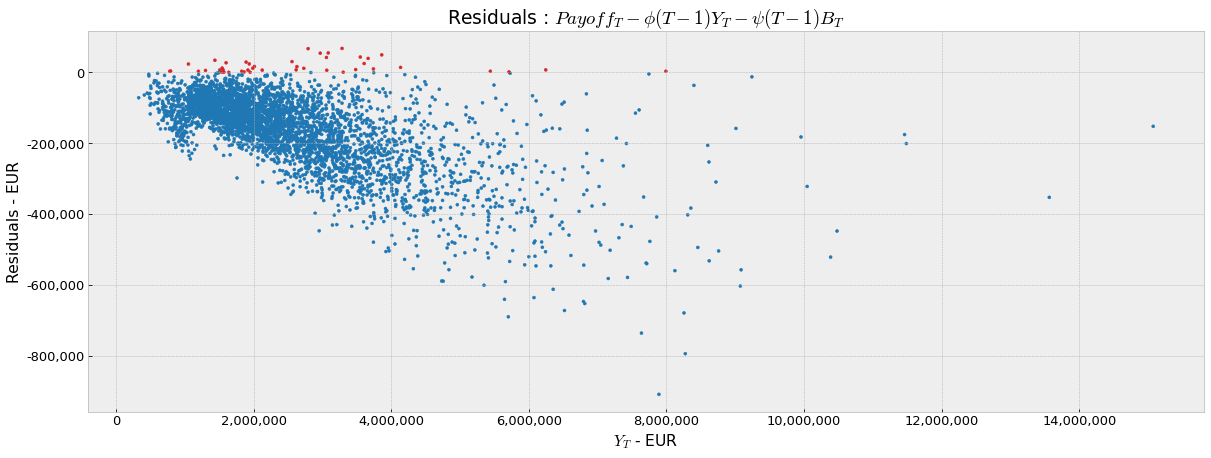

In [103]:
VaR_HV_df = pd.DataFrame(np.array(VaR_HV)[:,0], index=np.array(VaR_HV)[:,1], columns=['VaR'])
VaR_HV_df = VaR_HV_df * ADJUSTMENT_FACTOR
residuals = VaR_HV_df.loc[10].values 
c = ['tab:red' if r else 'tab:blue' for r in residuals > 0]
fig, ax = plt.subplots()
plt.scatter(Y_paths[:,-1]* ADJUSTMENT_FACTOR, residuals, color=c, marker='.')
plt.xlabel(r'$Y_{T}$ - EUR'), plt.ylabel('Residuals - EUR')
plt.title(r'Residuals : $Payoff_T - \phi(T-1)Y_T - \psi(T-1)B_T$')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))
ax.xaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

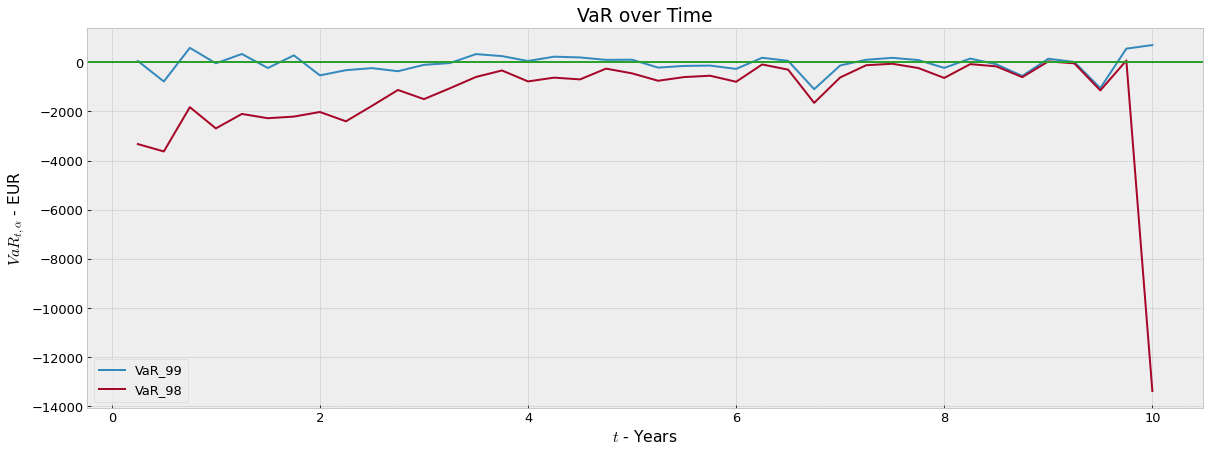

Overall VaR(98.5%) = -121.96 EUR
Overall VaR(99.0%) = 54.38 EUR
Overall VaR(99.5%) = 1160.76 EUR


In [104]:
ax = VaR_HV_df.groupby(level=0).aggregate(
    VaR_99=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .99)),
    VaR_98=pd.NamedAgg(column="VaR", aggfunc = lambda x: np.quantile(x, .98)),
    ).plot(title=r'VaR over Time', xlabel=r'$t$ - Years', ylabel=r'$VaR_{t,\alpha}$ - EUR')
ax.axhline(0, color='tab:green') ; plt.show()
print(f'Overall VaR(98.5%) = {np.quantile(VaR_HV_df.values, .985):.2f} EUR')
print(f'Overall VaR(99.0%) = {np.quantile(VaR_HV_df.values, .99):.2f} EUR')
print(f'Overall VaR(99.5%) = {np.quantile(VaR_HV_df.values, .995):.2f} EUR')

# Hedging Values

Phi t=0 : 643,687 Stocks
Psi t=0 : 350,888 Bonds


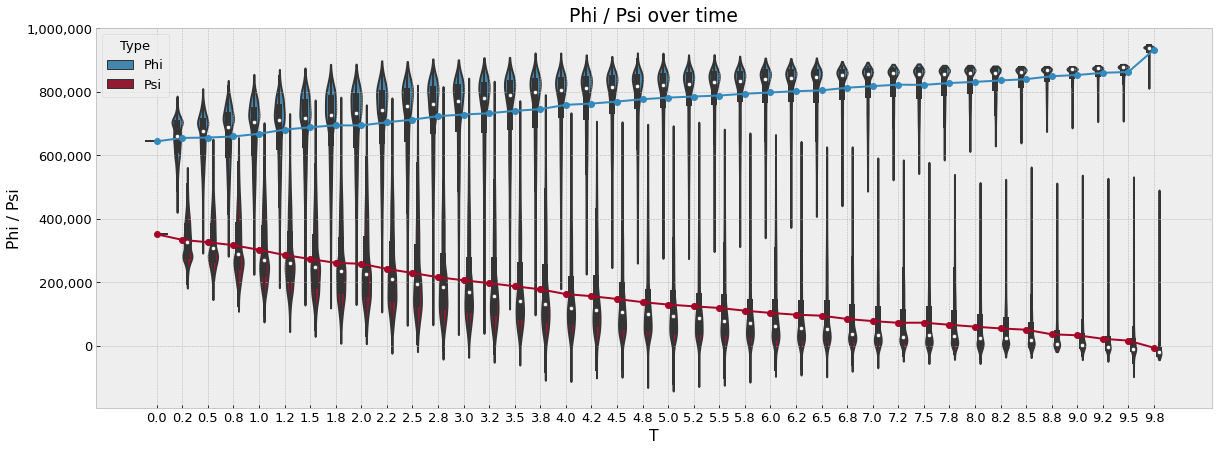

In [105]:
index = np.linspace(0, T, n_time_steps-1, endpoint = False)[::-1]
phi_psi_df = pd.DataFrame(Phi_Psi_HV, columns=['Value', 'T', 'Type'])
phi_psi_df.Value *= ADJUSTMENT_FACTOR 

ax = sns.violinplot(data=phi_psi_df, x="T", y="Value", hue="Type", dodge=1, cut=True)
ax.set_xticklabels([f'{x:,.1f}'for x in index][::-1])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

_ppg = phi_psi_df.groupby(['T', 'Type']).agg('mean')

title = 'Distribution of Phi/Psi over time'
phidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Phi'].groupby('T').mean().rename(columns={'Value':'Mean Phi'})['Mean Phi']
psidf = _ppg.loc[_ppg.index.get_level_values('Type') == 'Psi'].groupby('T').mean().rename(columns={'Value':'Mean Psi'})['Mean Psi']
phidf.index = range(0, phidf.shape[0]) ; psidf.index = range(0, psidf.shape[0])
phidf.plot(marker='o', ax=ax) ; psidf.plot(marker='o', ax=ax) ; 
ax.set_ylabel('Phi / Psi') ; ax.set_title('Phi / Psi over time') #; ax.set_xlabel('T - Years')

print(f'Phi t=0 : {_ppg.loc[(0, "Phi")].mean():,.0f} Stocks')
print(f'Psi t=0 : {_ppg.loc[(0, "Psi")].mean():,.0f} Bonds')

# _ppg

ADJUSTED 
--------------------------------------------
Value at t_0 (Replicating-P)  = 981,038.213
Discounted Eq[S] ADJ          = 1,653,394.334
 Difference                   = -672,356.121 : -40.665%
Discounted Ep[S] ADJ          = 866,260.460
 Difference                   = 114,777.752   : 13.250% 
Total Premium at t0           = 1,000,000 
Profit w/o TC                 = 18,962


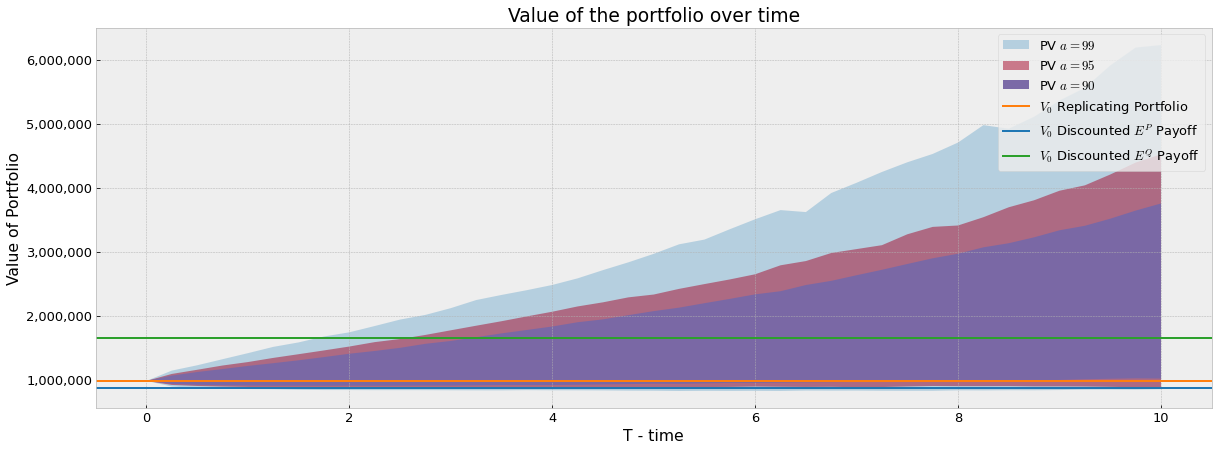

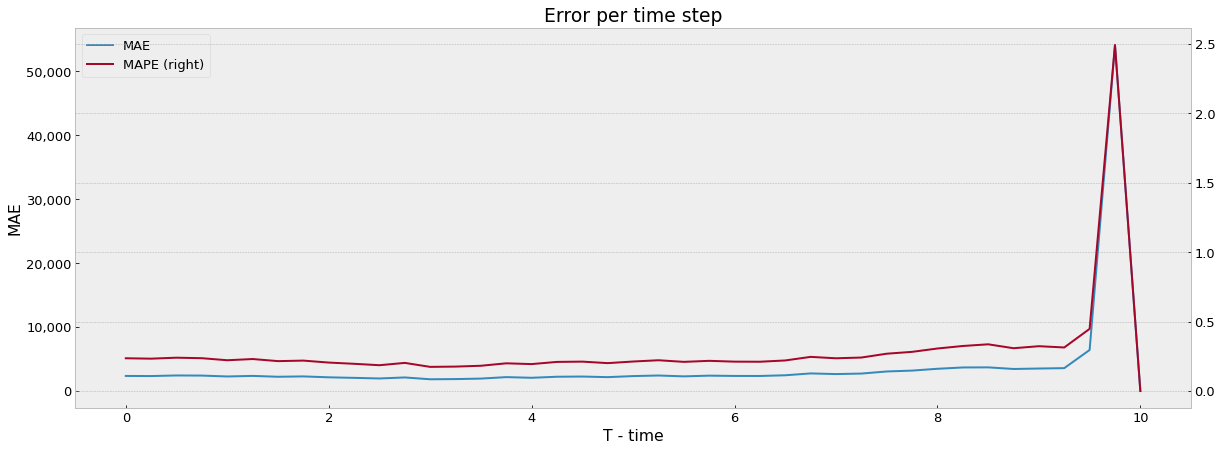

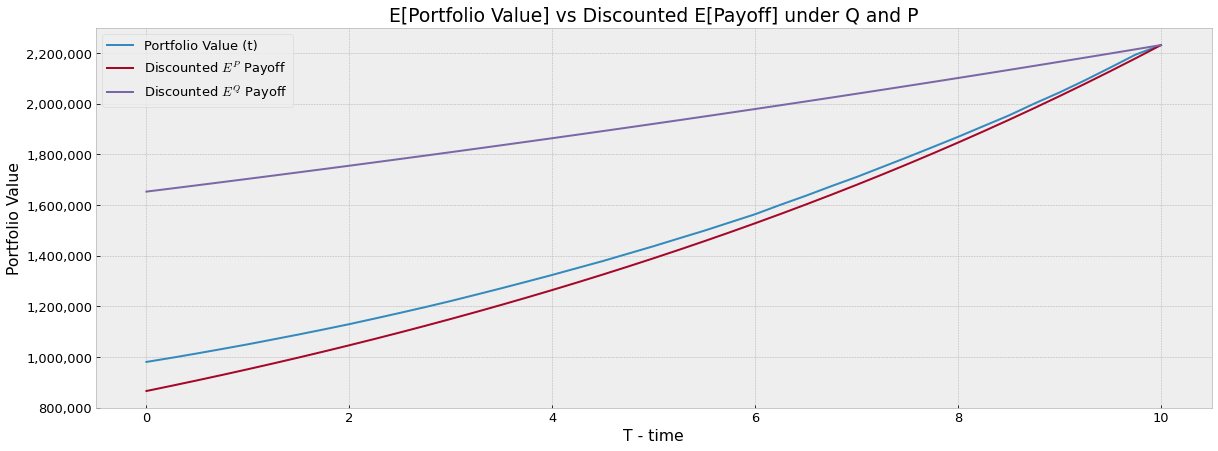

In [106]:
V0_RP = values[:,0].mean() * ADJUSTMENT_FACTOR

qs = np.quantile(values, q=[.99, .95, .9, .1, .05, .01], axis=0) * ADJUSTMENT_FACTOR
t  = np.linspace(0, T, n_time_steps)

fig, ax = plt.subplots()
ax.fill_between(t, qs[0,:].squeeze(), qs[-1,:].squeeze(), alpha=.3)
ax.fill_between(t, qs[1,:].squeeze(), qs[-2,:].squeeze(), alpha=.5)
ax.fill_between(t, qs[2,:].squeeze(), qs[-3,:].squeeze(), alpha=.99)
plt.ticklabel_format(style='plain', useLocale=True)
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}"))

ax.axhline(V0_RP, color='tab:orange')
ax.axhline(S_T.mean() * np.exp(-mu*T), color='tab:blue')
ax.axhline(S_T.mean() * np.exp(-r*T), color='tab:green')
ax.legend([r'PV $a=99$',r'PV $a=95$',r'PV $a=90$', r'$V_0$ Replicating Portfolio', r'$V_0$ Discounted $E^P$ Payoff', r'$V_0$ Discounted $E^Q$ Payoff'])
ax.set_xlabel('T - time') ; ax.set_ylabel('Value of Portfolio') ; ax.set_title('Value of the portfolio over time')

print('ADJUSTED \n--------------------------------------------')
print(f'Value at t_0 (Replicating-P)  = {V0_RP:,.3f}')
print(f'Discounted Eq[S] ADJ          = {S_T.mean() * np.exp(-r*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-r*T):,.3f} : {(V0_RP - S_T.mean() * np.exp(-r*T))/(S_T.mean() * np.exp(-r*T)) * 100:,.3f}%')
print(f'Discounted Ep[S] ADJ          = {S_T.mean() * np.exp(-mu*T):,.3f}')
print(f' Difference                   = {V0_RP - S_T.mean() * np.exp(-mu*T):,.3f}   : {(V0_RP - S_T.mean() * np.exp(-mu*T))/ (S_T.mean() * np.exp(-mu*T)) * 100:,.3f}% ')
print(f'Total Premium at t0           = {ADJUSTMENT_FACTOR:,} \nProfit w/o TC                 = {ADJUSTMENT_FACTOR - V0_RP:,.0f}')

Errors_df = pd.DataFrame(np.array(Errors[::-1]), index=t, columns=['MAE', 'MAPE'])
Errors_df['MAE'] = Errors_df['MAE'] * ADJUSTMENT_FACTOR
ax = Errors_df.plot(legend=True, title='Error per time step', ylabel='MAE', secondary_y=['MAPE'])
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

E_Port_Values_df = pd.DataFrame(np.array(P_E_Values[::-1]), index=t, columns=['Portfolio Value (t)', r'Discounted $E^P$ Payoff', r'Discounted $E^Q$ Payoff']) * ADJUSTMENT_FACTOR
ax = E_Port_Values_df.plot(legend=True, title='E[Portfolio Value] vs Discounted E[Payoff] under Q and P', ylabel='Portfolio Value')
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter("{x:,.0f}")) ; ax.set_xlabel('T - time')

plt.show()

# Hedging Simulations - Simple Model

In [109]:
parameters = {
    # """ Financial parameters """
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : mu,
    'r'       : 0.03,
    'sigma'   : sigma_0,

    'rebalancing' : 1/4,

    # """ Acturial Parameters """
    'N'   : 10_000,
    'P'   : 100,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,

    # """ Simulation parameters """
    'dt'      : 1/(100),
    'n_paths'  : ceil(np.log2(3_000))
}
import Replicating_Portfolio as RP
reload(RP)

phi, psi = RP.Replicating_Portfolio(parameters)

print(f'\n\nPhi t=0 : {phi:,.0f} Stocks')
print(f'Psi t=0 : {psi:,.0f} Bonds')

reduction = 25


  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.577, N_(10.00) = 0.862
8/8 [==============================] - 0s 6ms/step - loss: 6.7223e-04 - mae: 0.0183 - mape: 0.8985
VaR: -0.004277 (98%),  -0.001985 (99%)

>> Y_(9.75) = 2.518, N_(9.75) = 0.866
8/8 [==============================] - 0s 10ms/step - loss: 1.1401e-04 - mae: 0.0062 - mape: 0.4197
VaR: -0.002848 (98%),  -0.001784 (99%)

>> Y_(9.50) = 2.458, N_(9.50) = 0.871
8/8 [==============================] - 0s 6ms/step - loss: 5.8342e-05 - mae: 0.0034 - mape: 0.2762
VaR: -0.002537 (98%),  -0.001504 (99%)

>> Y_(9.25) = 2.401, N_(9.25) = 0.875
8/8 [==============================] - 0s 5ms/step - loss: 5.6662e-05 - mae: 0.0032 - mape: 0.2825
VaR: -0.000859 (98%),  -0.000335 (99%)

>> Y_(9.00) = 2.345, N_(9.00) = 0.879
8/8 [==============================] - 0s 4ms/step - loss: 5.1424e-05 - mae: 0.0031 - mape: 0.2687
VaR: -0.001831 (98%),  -0.001227 (99%)

>> Y_(8.75) = 2.289, N_(8.75) = 0.884
8/8 [==============================] - 0s 4ms/step - loss: 4.4712e-05 - m

In [110]:
init_parameters = parameters

results = []
for s in [.05, .10, .15, .20, .30]:
    print(f'\n\n\n>>{s}--------------------------------')
    parameters['sigma'] = s
    phi, psi = RP.Replicating_Portfolio(parameters)
    results.append([phi, psi])




>>0.05--------------------------------
reduction = 25


  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.575, N_(10.00) = 0.862
8/8 [==============================] - 0s 7ms/step - loss: 1.4438e-05 - mae: 0.0030 - mape: 0.1352
VaR: -0.007978 (98%),  -0.002162 (99%)

>> Y_(9.75) = 2.515, N_(9.75) = 0.866
8/8 [==============================] - 0s 5ms/step - loss: 2.0718e-05 - mae: 0.0035 - mape: 0.1614
VaR: -0.002835 (98%),  -0.001351 (99%)

>> Y_(9.50) = 2.456, N_(9.50) = 0.871
8/8 [==============================] - 0s 6ms/step - loss: 9.3086e-06 - mae: 0.0024 - mape: 0.1134
VaR: -0.008123 (98%),  -0.007337 (99%)

>> Y_(9.25) = 2.399, N_(9.25) = 0.875
8/8 [==============================] - 0s 5ms/step - loss: 8.0717e-06 - mae: 0.0022 - mape: 0.1075
VaR: -0.032142 (98%),  -0.031005 (99%)

>> Y_(9.00) = 2.343, N_(9.00) = 0.879
8/8 [==============================] - 0s 4ms/step - loss: 6.4916e-06 - mae: 0.0020 - mape: 0.0992
VaR: -0.014786 (98%),  -0.014099 (99%)

>> Y_(8.75) = 2.288, N_(8.75) = 0.884
8/8 [==============================] - 0s 4ms/step - loss: 5.7297e-06 - ma

  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.576, N_(10.00) = 0.862
8/8 [==============================] - 0s 8ms/step - loss: 4.7740e-05 - mae: 0.0041 - mape: 0.2150
VaR: -0.021441 (98%),  -0.016385 (99%)

>> Y_(9.75) = 2.516, N_(9.75) = 0.866
8/8 [==============================] - 0s 6ms/step - loss: 1.0330e-04 - mae: 0.0080 - mape: 0.3800
VaR: -0.003949 (98%),  -0.001633 (99%)

>> Y_(9.50) = 2.457, N_(9.50) = 0.871
8/8 [==============================] - 0s 6ms/step - loss: 2.3355e-06 - mae: 0.0012 - mape: 0.0568
VaR: -0.022985 (98%),  -0.021558 (99%)

>> Y_(9.25) = 2.400, N_(9.25) = 0.875
8/8 [==============================] - 0s 4ms/step - loss: 2.9566e-06 - mae: 0.0013 - mape: 0.0655
VaR: -0.002296 (98%),  -0.001918 (99%)

>> Y_(9.00) = 2.344, N_(9.00) = 0.879
8/8 [==============================] - 0s 4ms/step - loss: 2.1236e-06 - mae: 0.0011 - mape: 0.0576
VaR: -0.001348 (98%),  -0.001061 (99%)

>> Y_(8.75) = 2.288, N_(8.75) = 0.884
8/8 [==============================] - 0s 5ms/step - loss: 2.0393e-06 - ma

  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.577, N_(10.00) = 0.862
8/8 [==============================] - 0s 7ms/step - loss: 9.5925e-04 - mae: 0.0223 - mape: 1.0466
VaR: -0.008051 (98%),  -0.002230 (99%)

>> Y_(9.75) = 2.518, N_(9.75) = 0.866
8/8 [==============================] - 0s 5ms/step - loss: 7.4900e-05 - mae: 0.0057 - mape: 0.3558
VaR: -0.001570 (98%),  -0.000810 (99%)

>> Y_(9.50) = 2.458, N_(9.50) = 0.871
8/8 [==============================] - 0s 4ms/step - loss: 3.4803e-05 - mae: 0.0027 - mape: 0.2113
VaR: -0.001815 (98%),  -0.000945 (99%)

>> Y_(9.25) = 2.401, N_(9.25) = 0.875
8/8 [==============================] - 0s 5ms/step - loss: 3.2747e-05 - mae: 0.0023 - mape: 0.1983
VaR: -0.000395 (98%),  0.000045 (99%)

>> Y_(9.00) = 2.345, N_(9.00) = 0.879
8/8 [==============================] - 0s 6ms/step - loss: 3.1524e-05 - mae: 0.0022 - mape: 0.1898
VaR: -0.000259 (98%),  0.000207 (99%)

>> Y_(8.75) = 2.289, N_(8.75) = 0.884
8/8 [==============================] - 0s 4ms/step - loss: 2.8282e-05 - mae:

  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.578, N_(10.00) = 0.862
8/8 [==============================] - 0s 6ms/step - loss: 0.0019 - mae: 0.0301 - mape: 1.5907
VaR: -0.005048 (98%),  -0.002869 (99%)

>> Y_(9.75) = 2.519, N_(9.75) = 0.866
8/8 [==============================] - 1s 110ms/step - loss: 3.5382e-04 - mae: 0.0102 - mape: 0.8548
VaR: -0.003370 (98%),  -0.001606 (99%)

>> Y_(9.50) = 2.459, N_(9.50) = 0.871
8/8 [==============================] - 0s 3ms/step - loss: 2.3208e-04 - mae: 0.0074 - mape: 0.6816
VaR: -0.002485 (98%),  -0.001140 (99%)

>> Y_(9.25) = 2.402, N_(9.25) = 0.875
8/8 [==============================] - 0s 7ms/step - loss: 2.2032e-04 - mae: 0.0070 - mape: 0.6601
VaR: -0.001541 (98%),  0.000034 (99%)

>> Y_(9.00) = 2.347, N_(9.00) = 0.879
8/8 [==============================] - 0s 5ms/step - loss: 2.0086e-04 - mae: 0.0073 - mape: 0.6705
VaR: -0.002669 (98%),  -0.001134 (99%)

>> Y_(8.75) = 2.289, N_(8.75) = 0.884
8/8 [==============================] - 0s 4ms/step - loss: 1.5707e-04 - mae: 

  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.578, N_(10.00) = 0.862
8/8 [==============================] - 0s 9ms/step - loss: 0.0037 - mae: 0.0404 - mape: 2.5486
VaR: -0.010094 (98%),  0.003730 (99%)

>> Y_(9.75) = 2.522, N_(9.75) = 0.866
8/8 [==============================] - 0s 6ms/step - loss: 7.5211e-04 - mae: 0.0178 - mape: 1.6557
VaR: -0.046426 (98%),  -0.044398 (99%)

>> Y_(9.50) = 2.460, N_(9.50) = 0.871
8/8 [==============================] - 0s 5ms/step - loss: 6.8648e-04 - mae: 0.0169 - mape: 1.5895
VaR: 0.000262 (98%),  0.005856 (99%)

>> Y_(9.25) = 2.403, N_(9.25) = 0.875
8/8 [==============================] - 0s 4ms/step - loss: 4.5408e-04 - mae: 0.0148 - mape: 1.2504
VaR: 0.013821 (98%),  0.015135 (99%)

>> Y_(9.00) = 2.349, N_(9.00) = 0.879
8/8 [==============================] - 0s 5ms/step - loss: 0.0010 - mae: 0.0206 - mape: 1.8623
VaR: -0.028139 (98%),  -0.008674 (99%)

>> Y_(8.75) = 2.288, N_(8.75) = 0.884
8/8 [==============================] - 0s 5ms/step - loss: 6.0543e-04 - mae: 0.0161 - m

In [111]:
d = {}
for idx, s in enumerate([.05, .10, .15, .20, .30]):
    d[s] = [results[idx][0], results[idx][1], results[idx][0]+results[idx][1]]

_df = pd.DataFrame.from_dict(d, orient='index', columns=['Phi', 'Psi', 'Replicated Portfolio'])
_df.index.name = 'sigma' 
_df

,Phi,Psi,Replicated Portfolio
sigma,,,
0.05,896236.240864,14488.995075,9.107252e+05
0.10,892169.296741,18210.105598,9.103794e+05
0.15,635912.120342,331816.464663,9.677286e+05
0.20,574618.518353,479856.312275,1.054475e+06
0.30,687849.521637,534581.005573,1.222431e+06


# Stochastic Volatility

In [112]:
sv_parameters = {
    # """ Financial parameters """
    'Y'       : 1,
    'K'       : 1,
    'T'       : 10, # Years
    'mu'      : 0.09620,
    'r'       : 0.03,
    's0'      : 0.16679,

    'rebalancing' : 1/4,

    # SV paramters
    'a'        :0.0033281299103885727, 
    'b'        :0.1562947229160206, 
    'c'        :0.01583113545983743,
    
    # """ Acturial Parameters """
    'N'   : 10_000,
    'P'   : 100,
    'x'   : 55.0, # yo
    'l0'  : 0.01,
    'c'   : 0.075,
    'ita' : 0.000597,

    # """ Simulation parameters """
    'dt'      : 1/(100),
    'n_paths'  : ceil(np.log2(3_000))
}
import Replicating_Portfolio as RP
reload(RP)

phi, psi = RP.Replicating_Portfolio_SV(sv_parameters)

print(f'\n\nPhi t=0 : {phi:,.0f} Stocks')
print(f'Psi t=0 : {psi:,.0f} Bonds')

----------------------------------------------------------------
reduction = 25


  0%|          | 0/40 [00:00<?, ?it/s]


>> Y_(10.00) = 2.604, N_(10.00) = 0.862
8/8 [==============================] - 0s 9ms/step - loss: 7.9307e-04 - mae: 0.0197 - mape: 0.9633
VaR: -0.005781 (98%),  -0.003780 (99%)

>> Y_(9.75) = 2.539, N_(9.75) = 0.866
8/8 [==============================] - 0s 6ms/step - loss: 1.3630e-04 - mae: 0.0079 - mape: 0.5228
VaR: -0.002737 (98%),  -0.001053 (99%)

>> Y_(9.50) = 2.481, N_(9.50) = 0.871
8/8 [==============================] - 0s 4ms/step - loss: 6.5029e-05 - mae: 0.0049 - mape: 0.3530
VaR: -0.001539 (98%),  -0.000664 (99%)

>> Y_(9.25) = 2.422, N_(9.25) = 0.875
8/8 [==============================] - 0s 5ms/step - loss: 5.3927e-05 - mae: 0.0041 - mape: 0.3148
VaR: -0.000243 (98%),  0.000721 (99%)

>> Y_(9.00) = 2.365, N_(9.00) = 0.879
8/8 [==============================] - 0s 9ms/step - loss: 4.2831e-05 - mae: 0.0036 - mape: 0.2757
VaR: -0.001982 (98%),  -0.000920 (99%)

>> Y_(8.75) = 2.309, N_(8.75) = 0.884
8/8 [==============================] - 0s 4ms/step - loss: 3.3975e-05 - mae